<a href="https://colab.research.google.com/github/o-fugi/FURSPColexification/blob/main/semantic_relations_empirical_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gensim.downloader as gs
import numpy as np
import pandas as pd
import torch
import re
from torch import nn
import math
import pickle
import matplotlib.pyplot as plt
from functools import reduce
from scipy.special import softmax
from scipy.spatial import distance

In [ ]:
! pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('whaleloops/phrase-bert')

In [ ]:
df_concrete = pd.read_csv('drive/MyDrive/FURSP/brysbaert_concreteness.csv') # Word, Conc.M
df_valence = pd.read_csv('drive/MyDrive/FURSP/Ratings_Warriner_et_al.csv') # Word, V.Mean.Sum [or A for arousal, D for dominance]

In [163]:
# Methods to calculate valence and concreteness of a sense

def calc_valence(sense: str):
  s = sense.lower()
  phrases = re.split('/|,', s)
  total_valence = 0
  valence_data = 0
  for p in phrases:
    p = p.strip()
    if (len(p.split(' ')) > 1) & (p.split(' ')[0] == 'to'):
      p = re.sub("^to ", "", p)
    # This line removes all parts between parentheses:
    # p = re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", p)
    try:
      valence = df_valence[df_valence['Word']==p]['V.Mean.Sum'].values[0]
      if not np.isnan(valence):
        total_valence += valence
        valence_data += 1
    except:
      pass
  if valence_data == 0:
    total_valence = np.nan
  else:
    total_valence /= valence_data
  return total_valence

def calc_concrete(sense: str):
  s = sense.lower()
  phrases = re.split('/|,', s)
  total_conc = 0
  conc_data = 0
  for p in phrases:
    p = p.strip()
    if (len(p.split(' ')) > 1) & (p.split(' ')[0] == 'to'):
      p = re.sub("^to ", "", p)
    # This line removes all parts between parentheses:
    # p = re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", p)
    try:
      conc = df_concrete[df_concrete['Word']==p]['Conc.M'].values[0]
      if not np.isnan(conc):
        total_conc += conc
        conc_data += 1
    except:
      pass
  if conc_data == 0:
    total_conc = np.nan
  else:
    total_conc /= conc_data
  return total_conc

CLICS plots
---



In [77]:
NUM_LANGUAGE = 3156 # This is the number of languages used in the CLICS database
df_clics = pd.read_csv("drive/MyDrive/FURSP/clics-colexification-data.csv") # Change path as needed
df_clics.head()

,colex.freq,Concepticon_Gloss.xo,Concepticon_Gloss.yo,vision,assoc,affec,tax,fully_covered
0,340,TREE,WOOD,1,1,1,1,1
1,326,LEG,FOOT,1,1,1,1,1
2,296,MOON,MONTH,0,1,1,1,0
3,291,GO,WALK,0,1,1,1,0
4,284,HAND,ARM,1,1,1,1,1


In [93]:
senses_clics = list(pd.concat([df_clics['Concepticon_Gloss.xo'], df_clics['Concepticon_Gloss.yo']]).unique())

In [120]:
# Create dictionaries of sense -> valence and sense -> concreteness

valence_dict_clics = {}
concrete_dict_clics = {}
for i in range(len(senses_clics)):
  valence_dict_clics[senses_clics[i]] = calc_valence(senses_clics[i])
  concrete_dict_clics[senses_clics[i]] = calc_concrete(senses_clics[i])
  
def get_valence_clics(sense: str):
  return valence_dict_clics[sense]

def get_concrete_clics(sense: str):
  return concrete_dict_clics[sense]

In [119]:
# Create dictionary of sense -> phraseBERT embedding

sense_embs_clics = model.encode(senses_clics)
sense_embs_dict_clics = {}
for i in range(len(senses_clics)):
  sense_embs_dict_clics[senses_clics[i]] = sense_embs_clics[i]

def get_emb_clics(sense: str):
  return sense_embs_dict_clics[sense]

In [133]:
# Methods to create the values of the scatterplot (adding them into the original dataframe)

def get_cos_sim_clics(sense1: str, sense2: str):
  s1_emb = get_emb_clics(sense1)
  s2_emb = get_emb_clics(sense2)
  return 1 - distance.cosine(s1_emb, s2_emb)

def get_valence_dif_clics(sense1: str, sense2: str):
  return -abs(get_valence_clics(sense1) - get_valence_clics(sense2))

def get_concrete_dif_clics(sense1: str, sense2: str):
  return -abs(get_concrete_clics(sense1) - get_concrete_clics(sense2))

# Add the values of the scatterplot, based on desired semantic relation
def create_graph_vals_clics(relation: str):
  if relation == "relatedness":
    df_clics["cos_sim"] = df_clics.apply(lambda x : get_cos_sim_clics(x['Concepticon_Gloss.xo'], x['Concepticon_Gloss.yo']) , axis=1)
  elif relation == "orientation":
    df_clics["valence_dif"] = df_clics.apply(lambda x : get_valence_dif_clics(x['Concepticon_Gloss.xo'], x['Concepticon_Gloss.yo']) , axis=1)
  elif relation == "metaphoricity":
    df_clics["concrete_dif"] = df_clics.apply(lambda x : get_concrete_dif_clics(x['Concepticon_Gloss.xo'], x['Concepticon_Gloss.yo']) , axis=1)

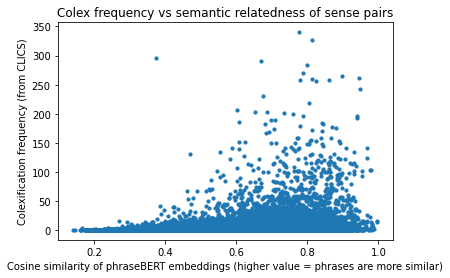

In [193]:
# Semantic relatedness scatterplot

create_graph_vals_clics("relatedness")
plt.scatter(df_clics["cos_sim"], df_clics["colex.freq"], s=10)
plt.title("Colex frequency vs semantic relatedness of sense pairs")
plt.xlabel("Cosine similarity of phraseBERT embeddings (higher value = phrases are more similar)")
plt.ylabel("Colexification frequency (from CLICS)")
plt.show()

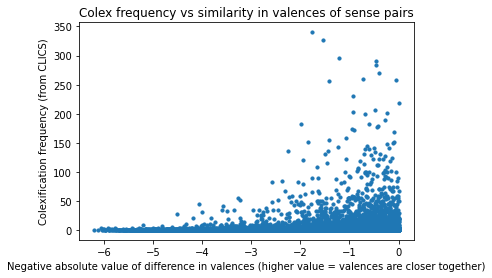

In [192]:
# Semantic orientation scatterplot

create_graph_vals_clics("orientation")
plt.scatter(df_clics["valence_dif"], df_clics["colex.freq"], s=10)
plt.title("Colex frequency vs similarity in valences of sense pairs")
plt.xlabel("Negative absolute value of difference in valences (higher value = valences are closer together)")
plt.ylabel("Colexification frequency (from CLICS)")
plt.show()

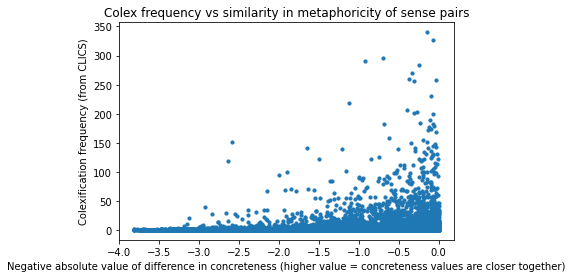

In [191]:
# Metaphoricity scatterplot

create_graph_vals_clics("metaphoricity")
plt.scatter(df_clics["concrete_dif"], df_clics["colex.freq"], s=10)
plt.title("Colex frequency vs similarity in metaphoricity of sense pairs")
plt.xlabel("Negative absolute value of difference in concreteness (higher value = concreteness values are closer together)")
plt.ylabel("Colexification frequency (from CLICS)")
plt.show()

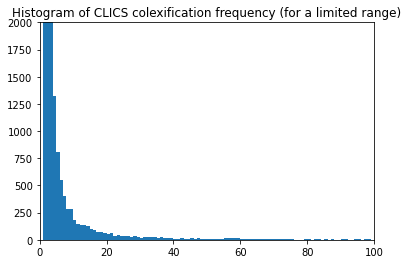

In [179]:
plt.title("Histogram of CLICS colexification frequency (for a limited range)")
plt.hist(df_clics["colex.freq"], bins=range(100))
plt.xlim(0, 100)
plt.ylim(0, 2000)
plt.show()


DatSemShift plots
---





In [141]:
datSemShift = pd.read_csv("drive/MyDrive/FURSP/datasemshift.csv")
datSemShift = datSemShift[(datSemShift['gendirection'] == '→')]
datSemShift = datSemShift[(datSemShift['type'] == ' Semantic evolution') | (datSemShift['type'] == ' Polysemy')]
datSemShift = datSemShift[(datSemShift['language1'] == datSemShift['language2'])]
datSemShift = datSemShift[(datSemShift['lexeme1'] == datSemShift['lexeme2'])]
datSemShift = datSemShift[~datSemShift['meaning1'].str.contains('<')]
datSemShift = datSemShift[(datSemShift['status']!='Suspended') & (datSemShift['status']!='Rejected')]

# Remove outliers
datSemShift = datSemShift[datSemShift["realizations"] < 250]

datSemShift.head()

,Unnamed: 0,id,class,meaning1,direction,meaning2,type,language1,language2,lexeme1,lexeme2,gendirection,status,comment,techcomment,contributor,realizations
0,0,1,V,"to calculate, count",→,to take into account,Polysemy,Sanskrit,Sanskrit,gaṇ,gaṇ,→,Accepted,NaN,NaN,AZ,13
3,3,1,V,"to calculate, count",—,to take into account,Polysemy,Russian,Russian,sčitat'sja,sčitat'sja,→,Accepted,NaN,NaN,AZ,13
4,4,1,V,"to calculate, count",—,to take into account,Polysemy,French,French,compter,compter,→,Accepted,NaN,NaN,AZ,13
5,5,1,V,"to calculate, count",NaN,to take into account,Polysemy,English,English,count,count,→,Accepted,NaN,NaN,AZ,13
6,6,1,V,"to calculate, count",NaN,to take into account,Polysemy,Turkish,Turkish,say-,say-,→,Accepted,NaN,NaN,AZ,13


In [142]:
df_dss = datSemShift.groupby(['meaning1', 'meaning2'], as_index=False).first()
df_dss.head()

,meaning1,meaning2,Unnamed: 0,id,class,direction,type,language1,language2,lexeme1,lexeme2,gendirection,status,comment,techcomment,contributor,realizations
0,(gun)powder,quick,13668,3441,Adj,→,Polysemy,Tigrinya,Tigrinya,barud,barud,→,Single*,None,None,MB,1
1,(gun)powder,small quantity of something,8352,1594,None,None,Polysemy,Tabassaran,Tabassaran,barut,barut,→,Single,,Только ли о сыпучих веществах?,TM,1
2,August,harvest,11040,2405,None,→,Polysemy,Mandarin Chinese,Mandarin Chinese,qiū (秋),qiū (秋),→,New,Buck 512,None,MR,2
3,Coleus (Plectranthus) rotundifolius,potato,19863,5843,None,→,Polysemy,Zulu,Zulu,izambane,izambane,→,New,None,None,MR,1
4,Easter,ladybird,19225,5629,None,→,Polysemy,Armenian,Armenian,zatik (զատիկ),zatik (զատիկ),→,New,None,None,MR,2


In [143]:
senses_dss = list(pd.concat([df_dss['meaning1'], df_dss['meaning2']]).unique())

In [144]:
# Create dictionaries of sense -> valence and sense -> concreteness

valence_dict_dss = {}
concrete_dict_dss = {}
for i in range(len(senses_dss)):
  valence_dict_dss[senses_dss[i]] = calc_valence(senses_dss[i])
  concrete_dict_dss[senses_dss[i]] = calc_concrete(senses_dss[i])
  
def get_valence_dss(sense: str):
  return valence_dict_dss[sense]

def get_concrete_dss(sense: str):
  return concrete_dict_dss[sense]

In [145]:
# Create dictionary of sense -> phraseBERT embedding

sense_embs_dss = model.encode(senses_dss)
sense_embs_dict_dss = {}
for i in range(len(senses_dss)):
  sense_embs_dict_dss[senses_dss[i]] = sense_embs_dss[i]

def get_emb_dss(sense: str):
  return sense_embs_dict_dss[sense]

In [146]:
# Methods to create the values of the scatterplot (adding them into the original dataframe)

def get_cos_sim_dss(sense1: str, sense2: str):
  s1_emb = get_emb_dss(sense1)
  s2_emb = get_emb_dss(sense2)
  return 1 - distance.cosine(s1_emb, s2_emb)

def get_valence_dif_dss(sense1: str, sense2: str):
  return get_valence_dss(sense2) - get_valence_dss(sense1) 

def get_concrete_dif_dss(sense1: str, sense2: str):
  return get_concrete_dss(sense2) - get_concrete_dss(sense1)

# Add the values of the scatterplot, based on desired semantic relation
def create_graph_vals_dss(relation: str):
  if relation == "relatedness":
    df_dss["cos_sim"] = df_dss.apply(lambda x : get_cos_sim_dss(x['meaning1'], x['meaning2']) , axis=1)
  elif relation == "orientation":
    df_dss["valence_dif"] = df_dss.apply(lambda x : get_valence_dif_dss(x['meaning1'], x['meaning2']) , axis=1)
  elif relation == "metaphoricity":
    df_dss["concrete_dif"] = df_dss.apply(lambda x : get_concrete_dif_dss(x['meaning1'], x['meaning2']) , axis=1)

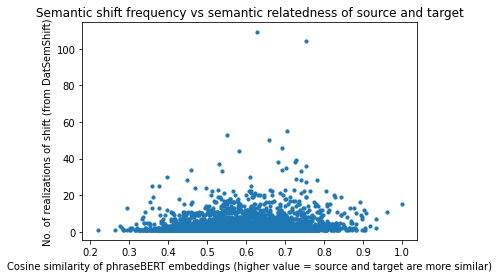

In [196]:
# Semantic relatedness scatterplot

create_graph_vals_dss("relatedness")
plt.scatter(df_dss["cos_sim"], df_dss["realizations"], s=10)
plt.title("Semantic shift frequency vs semantic relatedness of source and target")
plt.xlabel("Cosine similarity of phraseBERT embeddings (higher value = source and target are more similar)")
plt.ylabel("No. of realizations of shift (from DatSemShift)")
plt.show()

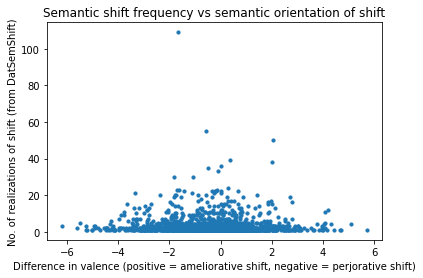

In [195]:
# Semantic orientation scatterplot

create_graph_vals_dss("orientation")
plt.scatter(df_dss["valence_dif"], df_dss["realizations"], s=10)
plt.title("Semantic shift frequency vs semantic orientation of shift")
plt.xlabel("Difference in valence (positive = ameliorative shift, negative = perjorative shift)")
plt.ylabel("No. of realizations of shift (from DatSemShift)")
plt.show()

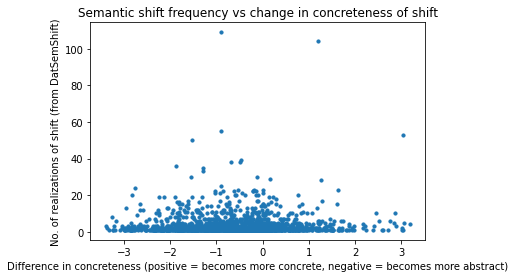

In [194]:
# Metaphoricity scatterplot

create_graph_vals_dss("metaphoricity")
plt.scatter(df_dss["concrete_dif"], df_dss["realizations"], s=10)
plt.title("Semantic shift frequency vs change in concreteness of shift")
plt.xlabel("Difference in concreteness (positive = becomes more concrete, negative = becomes more abstract)")
plt.ylabel("No. of realizations of shift (from DatSemShift)")
plt.show()

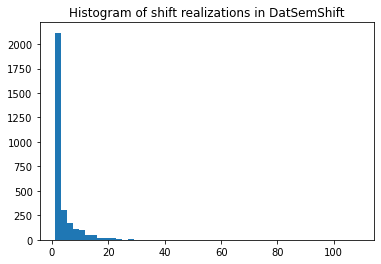

In [159]:
# Create histogram of shift realizations in DatSemShift

plt.title("Histogram of shift realizations in DatSemShift")
plt.hist(df_dss["realizations"], bins=50)
plt.show()